## Partie I: Preparation des données (preprocessing)

In [61]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from io import BytesIO #permet de stocker en mémoire
from zipfile import ZipFile

url2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip" #enquete 2019
url2020="https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip" #enquête 2020 en exemple

# Télécharge le fichier ZIP
requete = requests.get(url2019)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2019 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Télécharge le fichier ZIP
requete = requests.get(url2020)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2020 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

In [62]:
# On choisit un set de features qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié + qui sont disponibles sur les deux années étudiées

# label -> ACTEU

# features à inclure dans le modèle -> AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ; CSTOT (pour avoir actifs et inactifs) ;CSTOTR ;
# CSTOTPRM ; DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# USE? -> AIDFAM , CHPUB?? (Employeur de la profession principale?), EXTRIAN? (pondération)

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

# Je pense que le problème principal vient du fait qu'on a en fait trop peu de variable, et donc rien qui ne puisse être vraiment pertinent en fait
#c'est pour cela que les algorithmes ne trouvent rien je pense. (Alexis)

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected]

list_var = list(EEC_2019.columns.values)
print(list_var)

#je regarde ce qu'il se passe si je ne sépare pas les trimestres, le prof avait l'air de dire que c'était pas forcément grave (Alexis)
#EEC_2019 = EEC_2019[EEC_2019['TRIM'] ==1]
#EEC_2020 = EEC_2020[EEC_2020['TRIM'] ==4]

# Il y a très peu de valeurs manquantes dans les variables ->  dropna() drops any row that contains at least one missing value
# On aurait aussi pu faire de l'imputation
print(EEC_2019.shape)
EEC_2019 = EEC_2019.dropna() 
EEC_2020 = EEC_2020.dropna() 
print(EEC_2019.shape)

# Converti l'ensemble des variables catégorielles en dummies
# Oui oui faut le faire, par contre pour les variables qui sont DEJA des dummies, c'est pas la peine, faut juste les recoder en 0 et 1
EEC_2019 = pd.get_dummies(EEC_2019, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11", "NFRRED" , "TYPMEN7"])
EEC_2020 = pd.get_dummies(EEC_2020, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11", "NFRRED" , "TYPMEN7"])

#RECODAGE variables binaires (dummies)

EEC_2019['EMPLOI'] = EEC_2019['ACTEU'].apply(lambda x: x == 1)
EEC_2020['EMPLOI'] = EEC_2020['ACTEU'].apply(lambda x: x == 1)


EEC_2019['FEMME'] = EEC_2019['SEXE'].apply(lambda x: x == 2)
EEC_2020['FEMME'] = EEC_2020['SEXE'].apply(lambda x: x == 2)

EEC_2019['COUPLE'] = EEC_2019['COURED'].apply(lambda x: x == 2)
EEC_2020['COUPLE'] = EEC_2020['COURED'].apply(lambda x: x == 2)

EEC_2019['ENFANT'] = EEC_2019['ENFRED'].apply(lambda x: x == 2)
EEC_2020['ENFANT'] = EEC_2020['ENFRED'].apply(lambda x: x == 2)


EEC_2019['DOM'] = EEC_2019['METRODOM'].apply(lambda x: x == 2)
EEC_2020['DOM'] = EEC_2020['METRODOM'].apply(lambda x: x == 2)

#Vire les anciennes
EEC_2019 = EEC_2019.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)
EEC_2020 = EEC_2020.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)

# 133 variables
print(EEC_2019.shape)

# Gestion des outliers??? Pas nécessaire ici puisqu'on fonctionne seulement avec des variables catégorielles


EEC_2019_subsample = EEC_2019.sample(n=1000, random_state=3) 


['ACTEU', 'ANNEE', 'TRIM', 'AGE3', 'AGE5', 'CATAU2010R', 'COURED', 'CSTOT', 'CSTOTR', 'CSTOTPRM', 'DIP11', 'ENFRED', 'METRODOM', 'NFRRED', 'SEXE', 'TYPMEN7']
(416298, 16)
(412028, 16)
(412028, 133)


In [63]:
# ATTENTION -> Il faut rebalancer notre jeu de données puisqu'on a bcp plus de non-chomeurs que de chomeurs

# Balanced sample avec prediction emploi
proportion_values = EEC_2019_subsample['EMPLOI'].value_counts(normalize=True)
print(proportion_values)

EMPLOI
False    0.549
True     0.451
Name: proportion, dtype: float64


In [56]:
# Description d'une feature pour check 0/1
variable_description = EEC_2019_subsample["FEMME"].describe()

print(variable_description)

count     10000
unique        2
top        True
freq       5188
Name: FEMME, dtype: object


In [64]:
# On transforme nos dataframes en array car sklearn est bien adapté pour travailler sur ce type de données

# Array contentant l'ensemble des variables explicatives (on exclut donc CHOMAGE/ANNEE/TRIM)
X = np.array(EEC_2019_subsample.drop(columns=["EMPLOI","ANNEE", "TRIM"]))

print(X.shape)
# Array contentant la variable expliquée
y = np.array(EEC_2019_subsample["EMPLOI"])

print(y.shape)

print(X[:10])
print(y[:10])


(1000, 130)
(1000,)
[[False False  True ...  True  True False]
 [False False  True ... False  True False]
 [False False  True ... False False False]
 ...
 [False False  True ... False  True False]
 [False False  True ... False  True  True]
 [False False  True ...  True  True False]]
[False False  True False False False False False False False]


In [4]:
#from sklearn.preprocessing import StandardScaler
# standardisation des variables explicatives,  c’est-à-dire de centrer et réduire chaque variable
# en la divisant par sa variance  -> pas utile pour mes variables catégorielles transformées en dummies

# std_scale = StandardScaler().fit(X_train)
# X_train_scaled = std_scale.transform(X_train)
# X_test_scaled = std_scale.transform(X_test)

# La standardisation permet une convergence plus rapide des algorithmes pour des variables réelles


In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, random_state=3)

## Partie II : Support Vector Machine

In [80]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


#SVC est le modèle SVM permettant la classification

# confusion matrix -> 
acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = SVC( C=param)
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
     # Predictions on training set
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    # Predictions on test set
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))



#  ATTENTION -> Peut etre faut-il travailler avec un autre critère de performance que accuracy pour selectionner le meilleur modèle ?? On retrouve les meme résultats avec accuracy ou f1 score



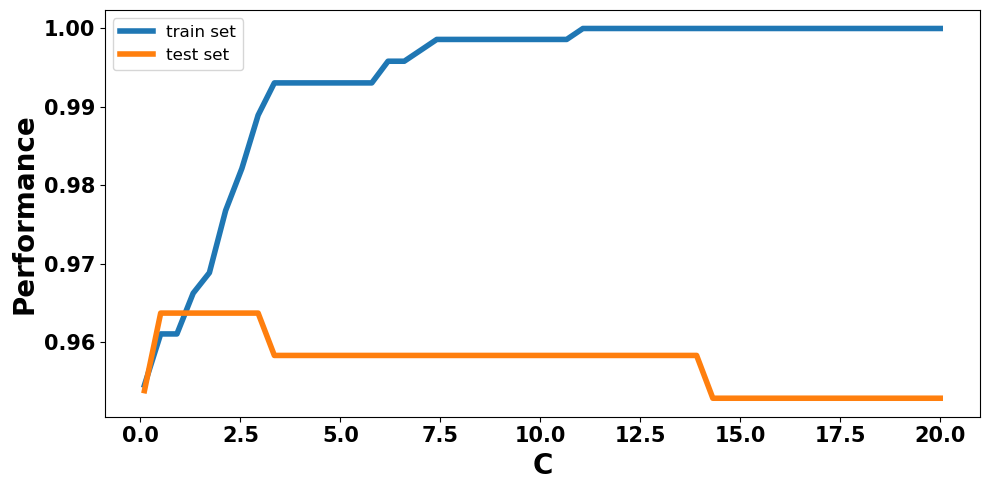

In [84]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='train set', lw=4)
plt.plot(C_range, f1_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


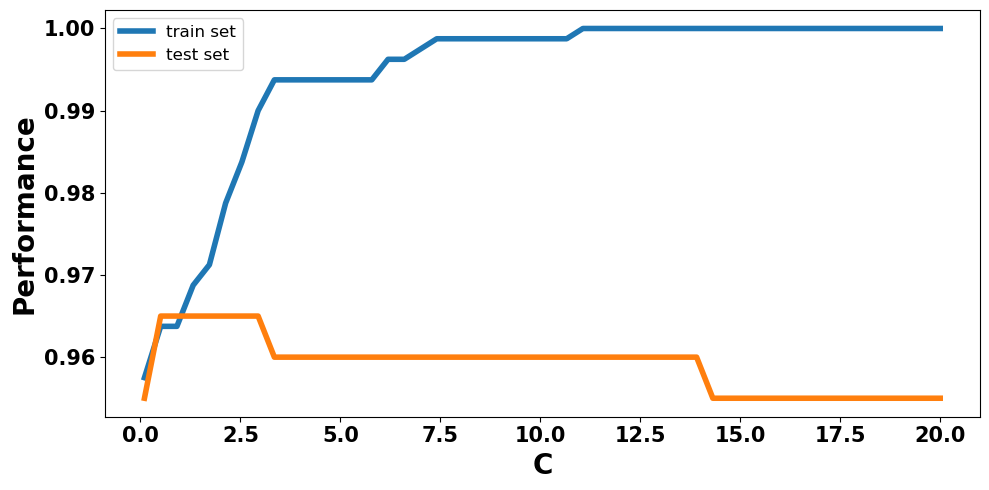

In [83]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, acc_train, label='train set', lw=4)
plt.plot(C_range, acc_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


[False False False False False False False]
(0, 133)
Empty DataFrame
Columns: [ANNEE, TRIM, AGE3_15, AGE3_30, AGE3_50, AGE5_15, AGE5_30, AGE5_40, AGE5_50, AGE5_60, CATAU2010R_1, CATAU2010R_2, CATAU2010R_3, CATAU2010R_4, CSTOT_0.0, CSTOT_11.0, CSTOT_12.0, CSTOT_13.0, CSTOT_21.0, CSTOT_22.0, CSTOT_23.0, CSTOT_31.0, CSTOT_33.0, CSTOT_34.0, CSTOT_35.0, CSTOT_37.0, CSTOT_38.0, CSTOT_42.0, CSTOT_43.0, CSTOT_44.0, CSTOT_45.0, CSTOT_46.0, CSTOT_47.0, CSTOT_48.0, CSTOT_52.0, CSTOT_53.0, CSTOT_54.0, CSTOT_55.0, CSTOT_56.0, CSTOT_62.0, CSTOT_63.0, CSTOT_64.0, CSTOT_65.0, CSTOT_67.0, CSTOT_68.0, CSTOT_69.0, CSTOT_71.0, CSTOT_72.0, CSTOT_74.0, CSTOT_75.0, CSTOT_77.0, CSTOT_78.0, CSTOT_81.0, CSTOT_84.0, CSTOT_85.0, CSTOT_86.0, CSTOTR_0.0, CSTOTR_1.0, CSTOTR_2.0, CSTOTR_3.0, CSTOTR_4.0, CSTOTR_5.0, CSTOTR_6.0, CSTOTR_7.0, CSTOTR_8.0, CSTOTPRM_0.0, CSTOTPRM_11.0, CSTOTPRM_12.0, CSTOTPRM_13.0, CSTOTPRM_21.0, CSTOTPRM_22.0, CSTOTPRM_23.0, CSTOTPRM_31.0, CSTOTPRM_33.0, CSTOTPRM_34.0, CSTOTPRM_35.0, CSTOT

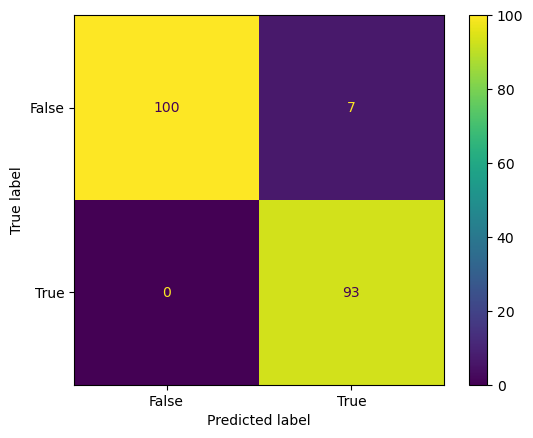

In [96]:
clf = SVC( C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [105]:
misclassified_indices = np.where(y_test != y_pred)[0]

# 7 personnes préditent comme des actifs occupés alors qu'ils sont inactifs/chomeurs / 0 personnes préditent pas actif occupés alors qu'ils le sont
print(y_test[misclassified_indices])


# ATTENTION -> est ce qu'on veut regarder si c'est des chomeurs ou des inactifs?

[False False False False False False False]


ValueError: operands could not be broadcast together with shapes (1000,130) (7,130) 

## Partie III - Regression logistique

In [136]:
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore", category=FutureWarning)

params= { 'C': np.linspace(0.1, 20, 50)}

# Régression logistique avec régularisation Ridge (régularisation L2)
lr =LogisticRegression(penalty='l2', dual=False, tol=0.01, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)

# Processus de cross-validation qui découpe notre échantillon en 5 et détermine le paramètre de régularisation optimal
# ATTENTION -> gain de selection des paramètres (cross validation) marginal par rapport à la selection des bonnes variables 
gs = GridSearchCV(estimator=lr, 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

results_df = pd.DataFrame(gs.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score']])

                       params  mean_test_score  std_test_score
0                  {'C': 0.1}          0.95625        0.011180
1   {'C': 0.5061224489795918}          0.96000        0.010897
2   {'C': 0.9122448979591836}          0.95750        0.015000
3   {'C': 1.3183673469387756}          0.95625        0.018114
4   {'C': 1.7244897959183674}          0.95375        0.017500
5   {'C': 2.1306122448979594}          0.95375        0.017500
6    {'C': 2.536734693877551}          0.95375        0.017500
7   {'C': 2.9428571428571426}          0.95375        0.017500
8   {'C': 3.3489795918367347}          0.95375        0.017500
9   {'C': 3.7551020408163267}          0.95375        0.020000
10   {'C': 4.161224489795918}          0.95250        0.021139
11  {'C': 4.5673469387755095}          0.95250        0.021139
12  {'C': 4.9734693877551015}          0.95375        0.020387
13  {'C': 5.3795918367346935}          0.95375        0.020387
14   {'C': 5.785714285714285}          0.95125        0

In [149]:
# On refait meme process en jouant en + sur le paramètre de penalty et le tol
# tol = tolerance for stopping criteria. It defines the stopping criterion for the solver to converge to a solution.
params= { 'C':np.linspace(0.1, 20, 50), 'penalty': ['l1','l2'],'tol': [0.01,0.1,1,10] }


gs = GridSearchCV(estimator=lr, 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

# This line calculates the accuracy of the best model found by the grid search on the specified sample
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 0.1, 'penalty': 'l1', 'tol': 0.01}
0.96375
0.965


In [143]:
acc_train, acc_test = list(), list()
C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = LogisticRegression(penalty='l1', dual=False, tol=0.01, C=param, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)
    
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))

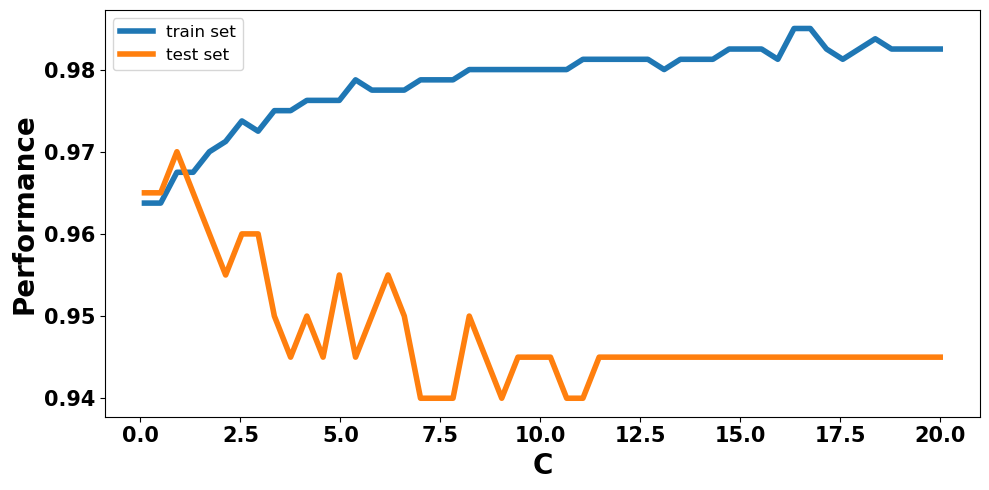

In [144]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, acc_train, label='train set', lw=4)
plt.plot(C_range, acc_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


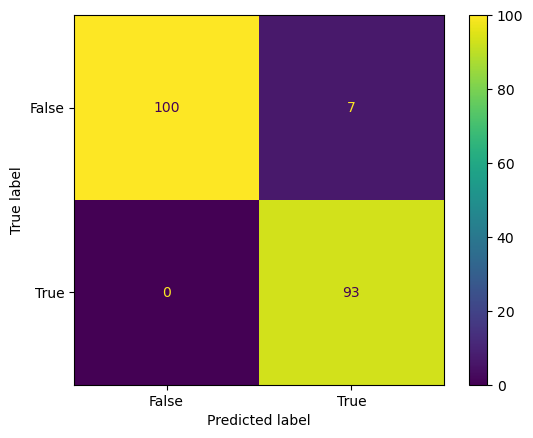

In [150]:
clf = LogisticRegression(penalty='l1', dual=False, tol=0.01, C=0.1, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

## Partie IV : Selections de variables

In [145]:
print(X[:100]) 

[[False False  True ...  True  True False]
 [False False  True ... False  True False]
 [False False  True ... False False False]
 ...
 [ True False False ...  True  True False]
 [False False  True ... False False  True]
 [False False  True ...  True  True False]]


In [146]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

clf = LassoCV()

# Je m'impose un maximum 20 features
sfm = SelectFromModel(clf, prefit=False, max_features=20)

sfm.fit(X,y)
X_transform = sfm.transform(X)
print(X_transform.shape)

(1000, 20)


In [152]:
from sklearn.linear_model import LogisticRegression

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2, random_state=3)

# Cherche la meilleure combinaison de paramètres à partir d'une grille: 
# 50 valeurs de regularisation
# Regularisation Lasso ou Ridge
# 3 valeurs de tolérance pour les critères d'arrêt
# (Le processus d'optimisation s'arrête lorsque la modification des coefficients est inférieure à la tolérance spécifiée)
params= { 'C':np.linspace(0.1, 20, 50), 'penalty': ['l1','l2'],'tol': [10, 1, 0.01,0.1] }


lr =LogisticRegression( dual=False, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)

gs = GridSearchCV(estimator=lr, 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

results_df = pd.DataFrame(gs.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score']])

# This line calculates the accuracy of the best model found by the grid search on the specified sample (important -> x_test)
print(gs.best_params_)
print(gs.score(X_train_2, y_train_2))
print(gs.score(X_test_2, y_test_2))

                                        params  mean_test_score  \
0       {'C': 0.1, 'penalty': 'l1', 'tol': 10}          0.55250   
1        {'C': 0.1, 'penalty': 'l1', 'tol': 1}          0.94500   
2     {'C': 0.1, 'penalty': 'l1', 'tol': 0.01}          0.96375   
3      {'C': 0.1, 'penalty': 'l1', 'tol': 0.1}          0.96375   
4       {'C': 0.1, 'penalty': 'l2', 'tol': 10}          0.55250   
..                                         ...              ...   
395   {'C': 20.0, 'penalty': 'l1', 'tol': 0.1}          0.96000   
396    {'C': 20.0, 'penalty': 'l2', 'tol': 10}          0.55250   
397     {'C': 20.0, 'penalty': 'l2', 'tol': 1}          0.96375   
398  {'C': 20.0, 'penalty': 'l2', 'tol': 0.01}          0.96625   
399   {'C': 20.0, 'penalty': 'l2', 'tol': 0.1}          0.96625   

     std_test_score  
0          0.003062  
1          0.021065  
2          0.009186  
3          0.009186  
4          0.003062  
..              ...  
395        0.012870  
396        0.003062

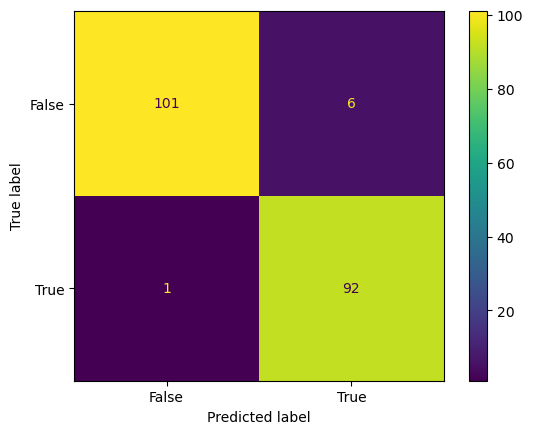

In [154]:
clf = LogisticRegression(penalty='l2', dual=False, tol=0.01, C=5.3795918367346935, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)


cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()